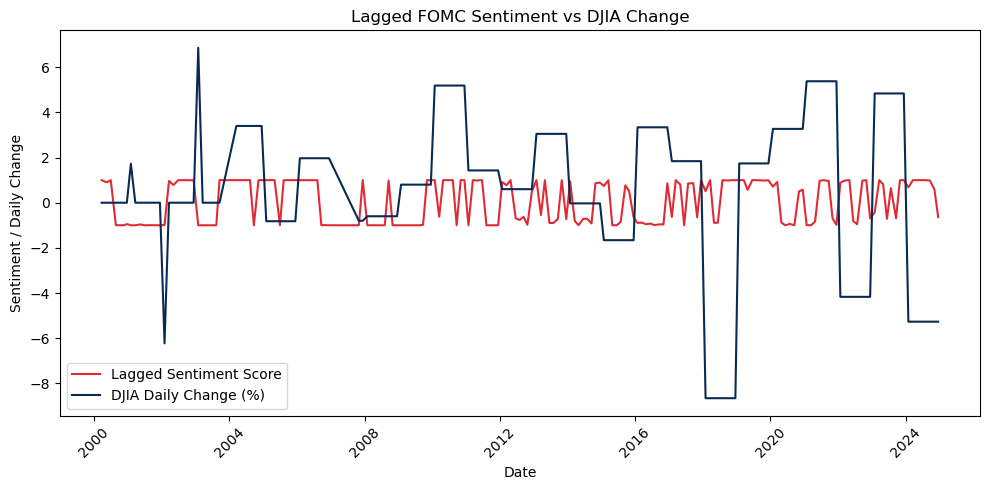

(-0.08456914002010915,
 0.24727460481401076,
 0.014164666691787729,
 0.8466066932738987,
 array([-0.08456914, -0.08799236, -0.03883762, -0.04781945, -0.0889362 ,
        -0.07743998, -0.02103711, -0.00785354, -0.03660347, -0.02596166]))

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import ccf
import pandas as pd

# Load the updated DJIA file with correct "Change %" column
djia_df = pd.read_csv("../content/Dow Jones Industrial Average Historical Data.csv")
fomc_df = pd.read_csv("../outputs/fomc_sentiment_results.csv")

# Correct sentiment score based on label
def correct_sentiment(row):
    return row["sentiment_score"] if row["sentiment_label"] == "Positive" else -row["sentiment_score"]

fomc_df["corrected_sentiment"] = fomc_df.apply(correct_sentiment, axis=1)

# Parse dates
djia_df["Date"] = pd.to_datetime(djia_df["Date"], format="%d/%m/%Y")
fomc_df["date"] = pd.to_datetime(fomc_df["date"], format="%Y-%m-%d")

# Convert Change % to numeric
djia_df["Change %"] = djia_df["Change %"].str.replace("%", "").astype(float) # convert to decimal

# Resample DJIA to daily (forward fill)
djia_daily = djia_df.set_index("Date").resample("D").ffill().reset_index()

# Merge with FOMC data
merged_df = pd.merge_asof(
    fomc_df.sort_values("date"),
    djia_daily.rename(columns={"Date": "date"}).sort_values("date"),
    on="date"
)

# Lagged sentiment
merged_df["sentiment_lag1"] = merged_df["corrected_sentiment"].shift(1)

# Drop NA values
clean_df = merged_df.dropna(subset=["sentiment_lag1", "Change %"])

# Correlation using actual "Change %"
pearson_corr, pearson_p = pearsonr(clean_df["sentiment_lag1"], clean_df["Change %"])
spearman_corr, spearman_p = spearmanr(clean_df["sentiment_lag1"], clean_df["Change %"])
ccf_vals = ccf(clean_df["sentiment_lag1"], clean_df["Change %"], adjusted=False)

# Plotting
plt.figure(figsize=(10, 5))

plt.plot(
    clean_df["date"],
    clean_df["sentiment_lag1"],
    label="Lagged Sentiment Score",
    color="#e02b35"
)

plt.plot(
    clean_df["date"],
    clean_df["Change %"],
    label="DJIA Daily Change (%)",
    color="#082a54"
)

plt.title("Lagged FOMC Sentiment vs DJIA Change")
plt.ylabel("Sentiment / Daily Change")
plt.xlabel("Date")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

(pearson_corr, pearson_p, spearman_corr, spearman_p, ccf_vals[:10])